# 서울시 구별 CCTV 현황 분석

 데이터를 파악하고, 시각화하는 방법에 집중하자.

In [55]:
# module import
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc

## 1. 데이터 읽기

In [13]:
# CCTV 데이터 확인
CCTV_Seoul = pd.read_csv("./data/01.CCTV_in_Seoul.csv", encoding='utf-8')
CCTV_Seoul.head()

,기관명,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강 남 구,5221,1944.0,195.0,316.0,430,546,765,577,448
1,강 동 구,1879,303.0,387.0,134.0,59,144,194,273,385
2,강 북 구,1265,243.0,88.0,141.0,74,145,254,1,319
3,강 서 구,1617,219.0,155.0,118.0,230,187,190,264,254
4,관 악 구,3985,430.0,56.0,419.0,487,609,619,694,671


In [14]:
# '기관명' 컬럼 변경
CCTV_Seoul.rename(columns={'기관명':'구별'}, inplace=True)
CCTV_Seoul.head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강 남 구,5221,1944.0,195.0,316.0,430,546,765,577,448
1,강 동 구,1879,303.0,387.0,134.0,59,144,194,273,385
2,강 북 구,1265,243.0,88.0,141.0,74,145,254,1,319
3,강 서 구,1617,219.0,155.0,118.0,230,187,190,264,254
4,관 악 구,3985,430.0,56.0,419.0,487,609,619,694,671


In [9]:
# 인구 데이터 확인 : 위의 두 줄 skip하여 읽기.
pop_Seoul = pd.read_csv("./data/01.population_in_Seoul.csv", encoding='utf-8', skiprows=[0,1])
pop_Seoul.head()

,기간,자치구,세대,계,남자,여자,계.1,남자.1,여자.1,계.2,남자.2,여자.2,세대당인구,65세이상고령자
0,2020.1/4,합계,4354006,10013781,4874995,5138786,9733655,4742217,4991438,280126,132778,147348,2.24,1518239
1,2020.1/4,종로구,74151,161984,78271,83713,151217,73704,77513,10767,4567,6200,2.04,28073
2,2020.1/4,중구,63045,136469,66769,69700,126175,61839,64336,10294,4930,5364,2.00,23794
3,2020.1/4,용산구,110895,246165,119961,126204,229579,110667,118912,16586,9294,7292,2.07,39439
4,2020.1/4,성동구,135643,307193,149891,157302,299042,146300,152742,8151,3591,4560,2.20,44728


In [11]:
# 필요 없는 컬럼 버리고, 이름 변경.
pop_Seoul.drop(['기간', '세대', '남자', '여자', '남자.1', '여자.1', '남자.2', '여자.2', '세대당인구'], axis=1, inplace=True)
pop_Seoul.rename(columns={'자치구':'구별', '계':'인구수', '계.1':'한국인', '계.2':'외국인', '65세이상고령자':'고령자'}, inplace=True)
pop_Seoul.head()

,구별,인구수,한국인,외국인,고령자
0,합계,10013781,9733655,280126,1518239
1,종로구,161984,151217,10767,28073
2,중구,136469,126175,10294,23794
3,용산구,246165,229579,16586,39439
4,성동구,307193,299042,8151,44728


In [25]:
# 수치형으로 바꿔 주기
pop_Seoul['인구수'] = pd.to_numeric(pop_Seoul['인구수'])
pop_Seoul['한국인'] = pd.to_numeric(pop_Seoul['한국인'])
pop_Seoul['외국인'] = pd.to_numeric(pop_Seoul['외국인'])
pop_Seoul['고령자'] = pd.to_numeric(pop_Seoul['고령자'])

In [26]:
# 사용하지 않는 합계 데이터 버리기
pop_Seoul.drop(0, axis=0, inplace=True)
pop_Seoul

,구별,인구수,한국인,외국인,고령자
1,종로구,161984,151217,10767,28073
2,중구,136469,126175,10294,23794
3,용산구,246165,229579,16586,39439
4,성동구,307193,299042,8151,44728
5,광진구,365990,350417,15573,48989
6,동대문구,362793,346156,16637,60367
7,중랑구,400678,395619,5059,66764
8,성북구,454532,442494,12038,72172
9,강북구,316750,312985,3765,61660
10,도봉구,333495,331238,2257,60023


## 2. 데이터 파악하기

### 2.1. CCTV

* 개수 현황 : 인구, 범죄율 등 관련 있는 요인들을 생각해 보자.
    - 상위 5개 구: 강남구, 관악구, 구로구, 성북구, 은평구.
    - 하위 5개 구: 도봉구, 중랑구, 강북구, 종로구, 중구.
    - 책에서는 2017 기준이어서, 마포구, 송파구가 각각 하위 2위, 3위였는데, 순위가 바뀌었다. 상위 5개 구도 강남, 은평 외에 바뀌었다.
* 증가율 상위 5개 구 : 종로구, 중구, 금천구, 영등포구, 관악구.
    - 관악구를 제외하고는, 증가율이 높은데도 불구하고 현재 개수가 상위 5개 구에 들어가는 구가 없다.
    - 2011년 이전 CCTV 개수 하위 5개 구 중 4개(종로구, 중구, 금천구, 영등포구)가 증가율 상위 5개 구와 겹친다. 원래 없던 구여서 늘린 것으로도 볼 수 있을 듯?

In [28]:
# 결측치 확인
CCTV_Seoul[CCTV_Seoul['구별'].isnull()]

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년,최근증가율


In [17]:
# 구별 CCTV 개수 순위 파악
display(CCTV_Seoul.sort_values(by='소계').head(5)) # 하위 5개 구
display(CCTV_Seoul.sort_values(by='소계', ascending=False).head(5)) # 상위 5개 구

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
9,도 봉 구,858,197.0,66.0,8.0,185,59,155,117,71
24,중 랑 구,1068,NaN,NaN,NaN,770,102,121,66,9
2,강 북 구,1265,243.0,88.0,141.0,74,145,254,1,319
22,종 로 구,1471,8.0,7.0,599.0,132,195,148,281,101
23,중 구,1544,25.0,165.0,114.0,80,245,270,317,328


,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강 남 구,5221,1944.0,195.0,316.0,430,546,765,577,448
4,관 악 구,3985,430.0,56.0,419.0,487,609,619,694,671
6,구 로 구,3227,852.0,219.0,349.0,187,268,326,540,486
16,성 북 구,3003,779.0,84.0,304.0,241,279,388,285,643
21,은 평 구,2962,1365.0,83.0,99.0,343,180,296,229,367


In [20]:
# CCTV 증가율 계산
CCTV_Seoul['최근증가율'] = ((CCTV_Seoul['2012년'] + CCTV_Seoul['2013년'] + CCTV_Seoul['2014년'] + CCTV_Seoul['2015년'] + \
                       CCTV_Seoul['2016년'] + CCTV_Seoul['2017년'] + CCTV_Seoul['2018년']) / CCTV_Seoul['2011년 이전']) * 100

In [22]:
# 증가율 상위 5개 구 확인
CCTV_Seoul.sort_values(by='최근증가율', ascending=False).head(5)

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년,최근증가율
22,종 로 구,1471,8.0,7.0,599.0,132,195,148,281,101,18287.500000
23,중 구,1544,25.0,165.0,114.0,80,245,270,317,328,6076.000000
7,금 천 구,1634,27.0,17.0,242.0,101,382,136,199,530,5951.851852
19,영등포구,2495,132.0,121.0,206.0,217,366,289,371,793,1790.151515
4,관 악 구,3985,430.0,56.0,419.0,487,609,619,694,671,826.744186


In [23]:
# 원래 적었던 구 알아보기
CCTV_Seoul.sort_values(by='2011년 이전').head(5)

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년,최근증가율
22,종 로 구,1471,8.0,7.0,599.0,132,195,148,281,101,18287.500000
23,중 구,1544,25.0,165.0,114.0,80,245,270,317,328,6076.000000
7,금 천 구,1634,27.0,17.0,242.0,101,382,136,199,530,5951.851852
19,영등포구,2495,132.0,121.0,206.0,217,366,289,371,793,1790.151515
9,도 봉 구,858,197.0,66.0,8.0,185,59,155,117,71,335.532995


### 2.2. 인구 수
* 현황
    - 상위 5개 구: 중구, 종로구, 용산구, 금천구, 성동구.
    - 하위 5개 구: 송파구, 강서구, 강남구, 노원구, 관악구.
    - 신기하게 인구 수가 많은 5개 구가 CCTV 현황이 적고, 적은 5개 구가 CCTV 현황이 많다. 인구 수보다 더 중요한 요인이 있나?
* 외국인 : 수와 비율 상위 5개 구가 약간 차이가 난다.
    - 외국인 수 상위 5개 구: 영등포구, 구로구, 금천구, 관악구, 동대문구.
    - 외국인 비율 상위 5개 구:  영등포구, 중구, 금천구, 구로구, 용산구.
* 고령자 : 수와 비율 상위 5개 구가 상대적으로 많이 차이 난다.
    - 고령자 수 상위 5개 구: 송파구, 강서구, 노원구, 은평구, 관악구.
    - 고령자 비율 상위 5개 구: 강북구, 도봉구, 중구, 종로구, 은평구.

* 특이한 점
    - 관악구는 인구 수는 적은데 외국인 수, 고령자 수 절대 수치 상위 5개 구 안에 들어간다.

In [30]:
# 결측치 확인
pop_Seoul[pop_Seoul['구별'].isnull()]

,구별,인구수,한국인,외국인,고령자


In [33]:
# 구별 외국인, 고령자 비율 계산
pop_Seoul['외국인비율'] = (pop_Seoul['외국인']/pop_Seoul['인구수'])*100
pop_Seoul['고령자비율'] = (pop_Seoul['고령자']/pop_Seoul['인구수'])*100

In [34]:
# 구별 인구수 상위, 하위 5개 구 확인
display(pop_Seoul.sort_values(by='인구수').head(5))
display(pop_Seoul.sort_values(by='인구수', ascending=False).head(5))

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
2,중구,136469,126175,10294,23794,7.543105,17.435462
1,종로구,161984,151217,10767,28073,6.646953,17.330724
3,용산구,246165,229579,16586,39439,6.737757,16.021368
18,금천구,251370,232583,18787,38508,7.473843,15.319251
4,성동구,307193,299042,8151,44728,2.653381,14.560228


,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
24,송파구,680883,674095,6788,89539,0.996941,13.150424
16,강서구,595703,589302,6401,85992,1.074529,14.435381
23,강남구,549898,544804,5094,72602,0.926354,13.202812
11,노원구,535495,531037,4458,82682,0.832501,15.440294
21,관악구,516662,499374,17288,76664,3.346095,14.838328


In [36]:
# 외국인 수, 외국인 비율 높은 구 확인
display(pop_Seoul.sort_values(by='외국인', ascending=False).head(5))
display(pop_Seoul.sort_values(by='외국인비율', ascending=False).head(5))

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,404766,371903,32863,59373,8.119012,14.668475
17,구로구,438308,405837,32471,67432,7.408261,15.384615
18,금천구,251370,232583,18787,38508,7.473843,15.319251
21,관악구,516662,499374,17288,76664,3.346095,14.838328
6,동대문구,362793,346156,16637,60367,4.585811,16.639516


,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,404766,371903,32863,59373,8.119012,14.668475
2,중구,136469,126175,10294,23794,7.543105,17.435462
18,금천구,251370,232583,18787,38508,7.473843,15.319251
17,구로구,438308,405837,32471,67432,7.408261,15.384615
3,용산구,246165,229579,16586,39439,6.737757,16.021368


In [37]:
# 고령자 수, 고령자 비율 높은 구 확인
display(pop_Seoul.sort_values(by='고령자', ascending=False).head(5))
display(pop_Seoul.sort_values(by='고령자비율', ascending=False).head(5))

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
24,송파구,680883,674095,6788,89539,0.996941,13.150424
16,강서구,595703,589302,6401,85992,1.074529,14.435381
11,노원구,535495,531037,4458,82682,0.832501,15.440294
12,은평구,482509,478019,4490,82245,0.930553,17.045278
21,관악구,516662,499374,17288,76664,3.346095,14.838328


,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
9,강북구,316750,312985,3765,61660,1.188635,19.466456
10,도봉구,333495,331238,2257,60023,0.676772,17.998171
2,중구,136469,126175,10294,23794,7.543105,17.435462
1,종로구,161984,151217,10767,28073,6.646953,17.330724
12,은평구,482509,478019,4490,82245,0.930553,17.045278


### 2.3. CCTV 데이터, 인구 데이터 병합 후 확인하기
* 상관관계
    - 구별 인구수와 CCTV 개수 : 약한 양의 상관관계.
    - 구별 외국인 비율과 CCTV 개수 : 큰 상관관계 없음.
    - 구별 고령자 비율과 CCTV 개수 : 중간 정도의 음의 상관관계.

In [52]:
# 구별로 CCTV 및 인구 데이터 병합
CCTV_Seoul['구별'] = CCTV_Seoul['구별'].str.replace(' ', '') # CCTV 데이터 구별 글자 오류 해결
data = pd.merge(CCTV_Seoul, pop_Seoul, on='구별')
data.head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,5221,1944.0,195.0,316.0,430,546,765,577,448,168.569959,549898,544804,5094,72602,0.926354,13.202812
1,강동구,1879,303.0,387.0,134.0,59,144,194,273,385,520.132013,457042,452646,4396,66401,0.961837,14.528424
2,강북구,1265,243.0,88.0,141.0,74,145,254,1,319,420.576132,316750,312985,3765,61660,1.188635,19.466456
3,강서구,1617,219.0,155.0,118.0,230,187,190,264,254,638.356164,595703,589302,6401,85992,1.074529,14.435381
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671,826.744186,516662,499374,17288,76664,3.346095,14.838328


In [53]:
# 필요없는 컬럼 삭제
data.drop(['2011년 이전', '2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년'], axis=1, inplace=True)
data.head()

,구별,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,5221,168.569959,549898,544804,5094,72602,0.926354,13.202812
1,강동구,1879,520.132013,457042,452646,4396,66401,0.961837,14.528424
2,강북구,1265,420.576132,316750,312985,3765,61660,1.188635,19.466456
3,강서구,1617,638.356164,595703,589302,6401,85992,1.074529,14.435381
4,관악구,3985,826.744186,516662,499374,17288,76664,3.346095,14.838328


In [54]:
# 구 이름으로 인덱스 설정
data.set_index('구별', inplace=True)
data.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,5221,168.569959,549898,544804,5094,72602,0.926354,13.202812
강동구,1879,520.132013,457042,452646,4396,66401,0.961837,14.528424
강북구,1265,420.576132,316750,312985,3765,61660,1.188635,19.466456
강서구,1617,638.356164,595703,589302,6401,85992,1.074529,14.435381
관악구,3985,826.744186,516662,499374,17288,76664,3.346095,14.838328


In [56]:
# 구별 인구수와 CCTV 개수의 상관관계 조사
np.corrcoef(data['소계'], data['인구수'])

array([[1.        , 0.38064812],
       [0.38064812, 1.        ]])

In [58]:
# 구별 외국인 비율과 CCTV 개수의 상관관계 조사
np.corrcoef(data['소계'], data['외국인비율'])

array([[ 1.        , -0.06215538],
       [-0.06215538,  1.        ]])

In [60]:
# 구별 고령자 비율과 CCTV 개수의 상관관계 조사
np.corrcoef(data['소계'], data['고령자비율'])

array([[ 1.        , -0.44225083],
       [-0.44225083,  1.        ]])

## 3. 데이터 시각화하기
* 인구와 CCTV의 관계
* 구별 고령자 비율과 CCTV 개수의 관계

In [61]:
plt.rcParams['axes.unicode_minus'] = False
path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

### 3.1. 인구와 CCTV의 관계
* CCTV의 수: 강남구가 가장 많은데, 관악구를 제외하면 다른 구들에 비해 월등히 많다.
* 인구 대비 CCTV 비율 : 중구, 용산구가 가장 높다. CCTV의 수에 비해 상위 구들과 그 미만의 차이가 적다.

* 확인
    - 송파구 : CCTV의 수, 인구 대비 CCTV 비율 모두 하위권.
    - 강남구, 관악구, 구로구, 영등포구 : 서울시 전체 구의 일반적인 경향보다 CCTV가 많이 설치됨.
    - 노원구, 강서구, 송파구, 강북구, 중랑구, 도봉구 : 서울시 전체 구의 일반적인 경향보다 CCTV가 적게 설치됨.

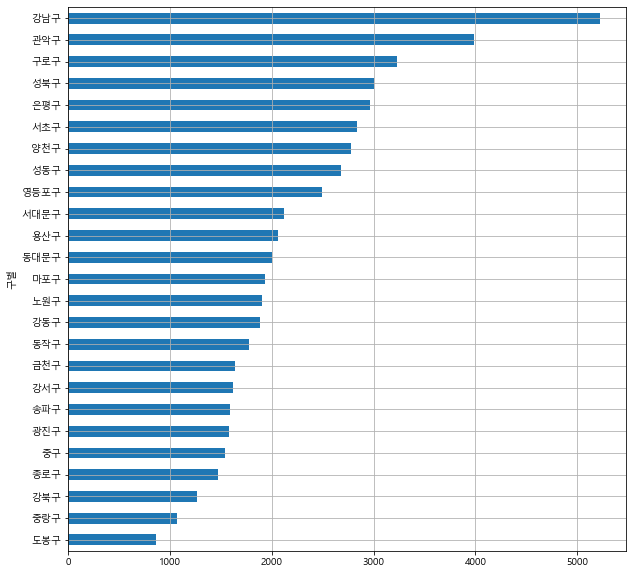

In [62]:
# CCTV 데이터 정렬 후 수평 막대 그래프로 표현
data['소계'].sort_values().plot(kind='barh', grid=True, figsize=(10, 10))
plt.show()

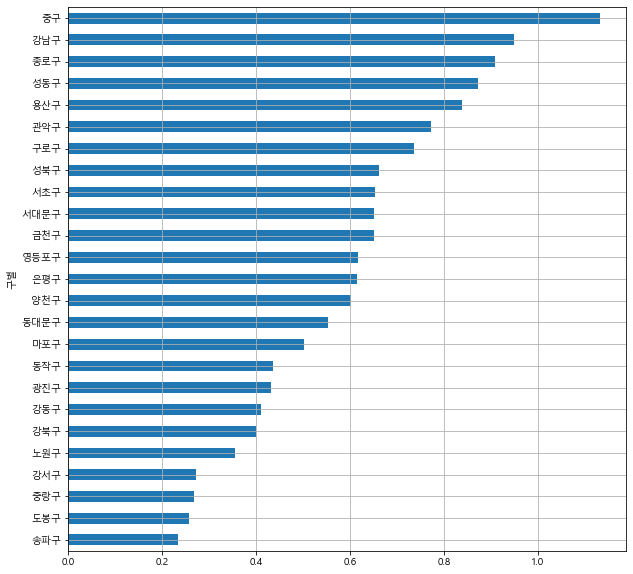

In [63]:
# 인구 수 대비 CCTV 비율 계산
data['인구대비CCTV비율'] = (data['소계']/data['인구수']) * 100

# 인구 수 대비 CCTV 비율 정렬 후 수평 막대 그래프로 표현
data['인구대비CCTV비율'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.show()

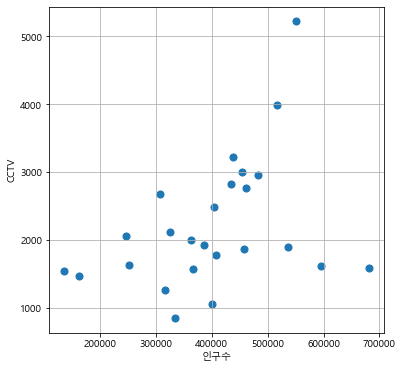

In [65]:
# 인구 수와 CCTV 수의 관계를 산점도로 표현
plt.figure(figsize=(6,6))
plt.scatter(data['인구수'], data['소계'], s=50)
plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.grid()
plt.show()

[2.88522756e-03 1.06403852e+03]
 
0.002885 x + 1064


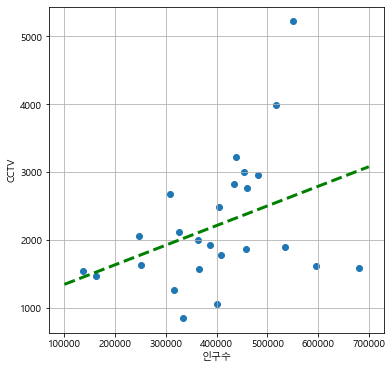

In [71]:
# 산점도를 대표하는 직선을 구해서 산점도와 함께 표현

# 데이터를 표현하는 일차식 구하기
fp1 = np.polyfit(data['인구수'], data['소계'], 1)
print(fp1) # 일차식의 계수

# 일차식을 그리기 위한 X축 범위 설정
fx = np.linspace(100000, 700000, 100)

# 일차식 : 일차식이 그려질 y축 설정.
f1 = np.poly1d(fp1)
print(f1) # 일차식

# 산점도와 함께 그림 그리기
plt.figure(figsize=(6, 6))
plt.scatter(data['인구수'], data['소계'])
plt.plot(fx, f1(fx), ls='dashed', lw=3, color='g')
plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.grid()
plt.show()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,인구대비CCTV비율,오차
구별,,,,,,,,,,
강남구,5221,168.569959,549898,544804,5094,72602,0.926354,13.202812,0.949449,2570.380612
송파구,1586,164.333333,680883,674095,6788,89539,0.996941,13.150424,0.232933,1442.540920
관악구,3985,826.744186,516662,499374,17288,76664,3.346095,14.838328,0.771297,1430.274035
도봉구,858,335.532995,333495,331238,2257,60023,0.676772,17.998171,0.257275,1168.247488
강서구,1617,638.356164,595703,589302,6401,85992,1.074529,14.435381,0.271444,1165.777237


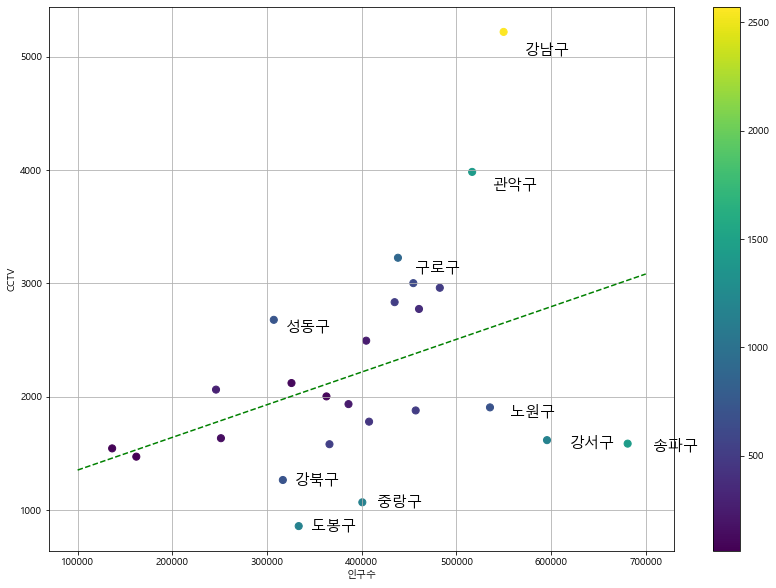

In [75]:
# 평균적인 선으로부터 멀리 있는 데이터를 다른 방법으로 표현

# 평균적인 선과의 오차 계산
data['오차'] = np.abs(data['소계'] - f1(data['인구수']))
df_sort = data.sort_values(by='오차', ascending=False) # 절댓값 오차 큰 구들을 구할 때 활용
display(df_sort.head())

# 산점도, 직선 그리기
plt.figure(figsize=(14,10))
plt.scatter(data['인구수'], data['소계'], c=data['오차'], s=50)
plt.plot(fx, f1(fx), ls='dashed', color='g')

# 오차가 큰 10개 구에 텍스트 표시
for n in range(10):
    plt.text(df_sort['인구수'][n]*1.04, df_sort['소계'][n]*0.96, df_sort.index[n],
            fontsize=15)

# 그림 그리기
plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.colorbar()
plt.grid()
plt.show()